In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
from sklearn import tree
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit,RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
df = pd.read_csv("KaggleV2-May-2016.csv")
print("Rows :", df.shape[0])
print("Columns:", df.shape[1])
df.head()

Rows : 110527
Columns: 14


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [29]:
df['Gender'] =df['Gender'].map({'M':1, 'F': 0})
df['No-show'] =df['No-show'].map({'Yes':1, 'No': 0})
df.rename(columns ={'AppointmentID': 'AppointmentId', 'Handcap': 'Handicap', 'Hipertension': 'Hypertension'}, inplace=True)
df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,2.987250e+13,5642903,0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,5.589978e+14,5642503,1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,4.262962e+12,5642549,0,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,8.679512e+11,5642828,0,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,8.841186e+12,5642494,0,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,0


Below is the split of values in 'No-show': 0 = showed up and 1 = didn't show up: 

No     88208
Yes    22319
Name: No-show, dtype: int64

 Out of 110527 records, 0 didn't show up, i.e. 0.0 %
Age range:  [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]


Text(0.5,1,'Distribution of Age')

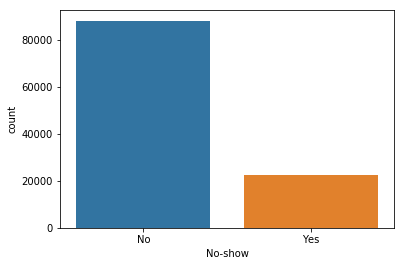

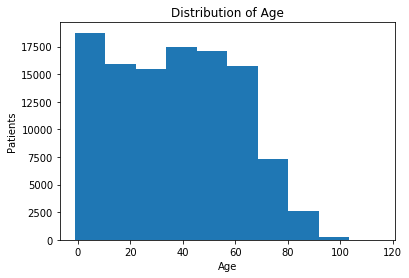

In [11]:
def no_show_class():
    '''Count the values of No-show to spot whether classes are imbalanced or not'''
    no_show = 0
    for value in df['No-show']:
        if value == 1:
            no_show += 1
    print ("\n Out of", len(df['No-show']), "records,", no_show, "didn't show up, i.e.", round(float(no_show) / float(len(df['No-show'])), 4)*100,"%")

print ("Below is the split of values in 'No-show': 0 = showed up and 1 = didn't show up: \n")
print (df['No-show'].value_counts())
sns.countplot(x='No-show', data=df)

no_show_class()

print ("Age range: ", sorted(df['Age'].unique()))

# Distribution of 'Age'
plt.figure();
age_hist = df['Age'].plot.hist(bins=10)
age_hist.set_xlabel("Age")
age_hist.set_ylabel("Patients")
age_hist.set_title('Distribution of Age') 

In [16]:
#Transformation of scheduled day and appointment day to date time objects
dt_scheduledDay = pd.to_datetime(df.ScheduledDay).dt.date
dt_appointmentDay = pd.to_datetime(df.AppointmentDay).dt.date

#Storing delta days to df with new feature
df['Days_delta'] = (dt_appointmentDay - dt_scheduledDay).dt.days
df.head()

df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['No_show_weekday'] = df['AppointmentDay'].dt.dayofweek


In [15]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Days_delta,No_show_weekday
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,4
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,4
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,4
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,4
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,4


In [18]:
# Creating histogram with number of days calculated
df = df[(df.Days_delta >= 0) & (df.Days_delta <= 70)]
print("Days delta: ", sorted(df.Days_delta.unique()))

Days delta:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


In [31]:
# Creating vars to hold categorical features for one hot encoding
cat_features_for_encoding = ['Handicap', 'Neighbourhood']

encoded_df = pd.get_dummies(df, columns=cat_features_for_encoding)
# Dropping all varchar/date features including labels from df
features = encoded_df.drop(['No-show', 'PatientId', 'AppointmentId', 'ScheduledDay', 'AppointmentDay'], axis=1)
features

,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,SMS_received,Handicap_0,Handicap_1,Handicap_2,...,Neighbourhood_SANTOS REIS,Neighbourhood_SEGURANÇA DO LAR,Neighbourhood_SOLON BORGES,Neighbourhood_SÃO BENEDITO,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM
0,0,62,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,56,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,62,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,8,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,56,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,76,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,23,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,39,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,21,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,19,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
